# Pulsar Classification Project Proposal
###### By Bernie Leung, Phillip Li, Glen Ren, and Helena Tremblay

### Introduction
Pulsars belong to a group of celestial objects called neutron stars, which are formed when suns collapse. When a sun has sufficient hydrogen fuel, it counteracts external gravitational force by creating pressure through constant nuclear reaction, thus reaching hydrostatic equilibrium. As these massive stars run out of hydrogen fuel, the core is no longer able to generate enough force to keep the celestial body from internally collapsing. The force from the collapse merges every proton and electron within it into a neutron (NASA, 2014).
Due to pulsars' nature of emitting rhythmic pulses of strong radiation because of their electromagnetism dipoles, they release light in regular intervals and look like they are twinkling when observed from earth. Pulsars are a main research interest within the scientific community because of their potential of helping us learn about the inter-stellar medium, states of matter, and space-time (Agarwal et al., 2020)

For this project, we will be using the HTRU2 dataset, with samples of pulsar candidates collected during the High Time Resolution Universe Survey, which “intends to be an all-sky survey for pulsars and short-duration radio transients, with a strong focus on the lower Galactic latitudes, [where the higher frequency resolution for the negation of interstellar dispersion are made used the most]” (Keith, 2010).
In this dataset, two main attributes are used to distinguish between the positive and negative class. The first is the Integrated Pulse Profile of the pulsar candidate, which is "an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency" (Lyon, 2016a). The second attribute is the DM-SNR curve of the candidate, which is the curve that describes the relationship between the density of electrons between the observer and observed candidate, known as the dispersion measure, and the candidate's signal to noise ratio (Lyon, 2016a). For each of the two attributes of a candidate, the following four statistical features are taken, generating eight total variable columns for each candidate:
- Mean
- Standard Deviation
- Skewness
- Excess Kurtosis

Our predictive question is to classify the pulsar candidates as either real pulsars or false candidates caused by RFI and noise. A binary classification system will be used to represent whether the pulsar is real or not. With 16,259 false candidates and 1,639 real pulsars that are checked by humans, the real pulsars are a minority positive class, and false candidates are the majority negative class in this dataset. The class labels used are 0 (false candidate) and 1 (real pulsar). The data itself is in two formats: CSV and ARFF. Each row corresponds to a candidate, each column a variable with the last column being the candidate's class.


### Methods & Results
First, we will load our libraries and our data from the web.

Since our data has improperly formatted column names, we will give new names to each column, in the proper style of lowercase and underscores.
We must also change the "class" column into a factor.

In [2]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)

pulsar_data <- read_csv("https://raw.githubusercontent.com/glenren/dsci_100_group_24/main/HTRU_2.csv", 
                        col_names = c("mean_int_prof", 
                                      "sd_int_prof",
                                      "kurt_int_prof",
                                      "skew_int_prof",
                                      "mean_curve",
                                      "sd_curve",
                                      "kurt_curve",
                                      "skew_curve",
                                      "class") ) %>%
                        mutate(class = as_factor(class))

# preview our data by showing the first six observations
head(pulsar_data)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

mean_int_prof,sd_int_prof,kurt_int_prof,skew_int_prof,mean_curve,sd_curve,kurt_curve,skew_curve,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


Now that our data is looking clean, we can explore it. In order to make a classifier, we must decide which predictors to use. Our method of choice is to create a summary data set by taking the mean value of each variable for both classes, and finding the differences in each variable between the two classes.

In [3]:
# summary data set
pulsar_averages <- pulsar_data %>%
    group_by(class) %>%
    summarize(across(mean_int_prof:skew_curve, mean))

pulsar_averages

`summarise()` ungrouping output (override with `.groups` argument)



class,mean_int_prof,sd_int_prof,kurt_int_prof,skew_int_prof,mean_curve,sd_curve,kurt_curve,skew_curve
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,116.56273,47.33974,0.2104401,0.380844,8.863258,23.28798,8.862674,113.62034
1,56.69061,38.71060,3.1306554,15.553576,49.825995,56.46896,2.757069,17.93173


In creating our summary data set we grouped the data points by class and applied the mean function to each of the variable columns for both classes using the across function. We then use a bar graph to represent the results found. However, because the summary table generated is not tidy (variables are each in a separate column instead of organized into a single column), we first have to create a dataframe that contains a tidied version of the summary table before passing that dataframe to the ggplot function.

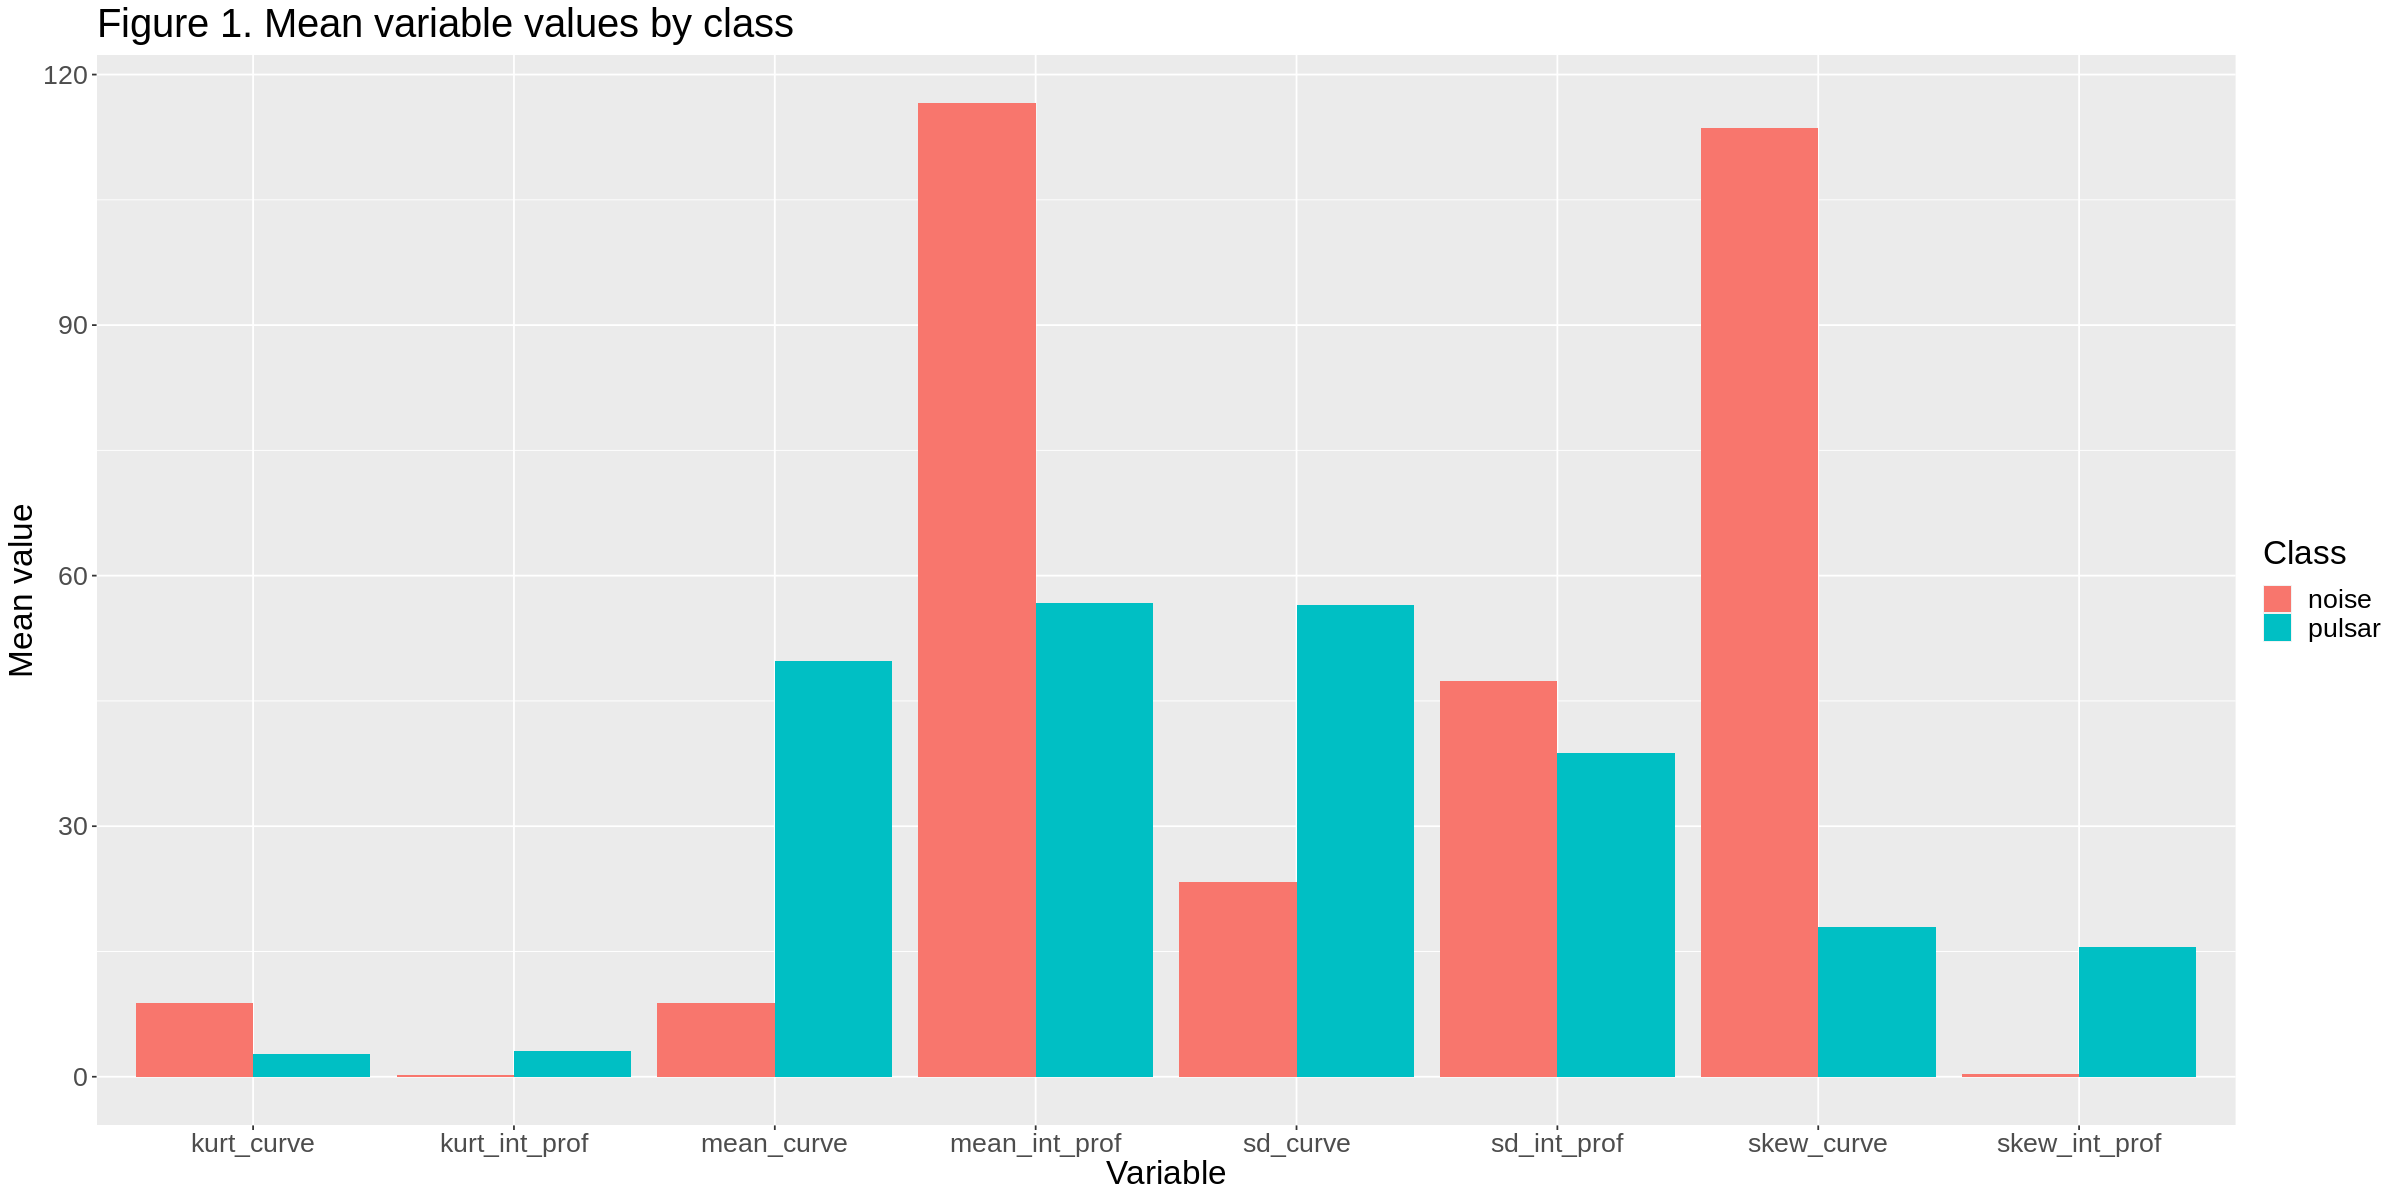

In [5]:
options(repr.plot.width = 20, repr.plot.height = 10) 

tidy_pulsar_averages <- pulsar_averages %>%
    pivot_longer(cols = mean_int_prof:skew_curve, # places all variables in a single column
                names_to = "variable",
                values_to = "mean_value")

averages_viz <- tidy_pulsar_averages %>%
    ggplot(aes(x = variable, y = mean_value, fill = class)) +
    geom_bar(stat = "Identity", position = "dodge") +
    labs(x = "Variable", y = "Mean value", fill = "Class") +
    theme(text = element_text(size=20)) +
    scale_fill_discrete(name = "Class", labels = c("noise", "pulsar")) +
    ggtitle("Figure 1. Mean variable values by class")

averages_viz

We can see that the mean values for mean_curve, mean_int_prof, sd_curve, and skew_curve seem to have the steepest difference between pulsar and non-pulsar observations (Figure 1). However, the data isn't scaled, which means that data points that are measured on a higher order of magnitude due to their unit of measurement might have a higher raw difference, but a lower relative difference than other variables. In order to see which variables vary the most between classes, we will examine the relative differences in value. 

Next, we'll take a look at the relative differences in value between the two classes for each variable to find out which variables vary the most between classes. To do this, we take our original pulsar_averages summary table (the untidy version) and find the percentage differences between the two rows. Like the averages table, the differences table is visualized by a bar graph, with the data first being tidied.

In [18]:
pulsar_differences <- slice(pulsar_averages, 2) - slice(pulsar_averages, 1) #raw difference in values

pulsar_percentage_difference <- abs(pulsar_differences/slice(pulsar_averages, 1)*100) #percentage difference - 
                                                                                      #absolute value taken for easier comparison
pulsar_percentage_difference

Warning message in Ops.factor(left, right):
“‘-’ not meaningful for factors”
Warning message in Ops.factor(left, right):
“‘/’ not meaningful for factors”


class,mean_int_prof,sd_int_prof,kurt_int_prof,skew_int_prof,mean_curve,sd_curve,kurt_curve,skew_curve
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,51.36472,18.22812,1387.671,3983.976,462.1634,142.4811,68.89123,84.21785


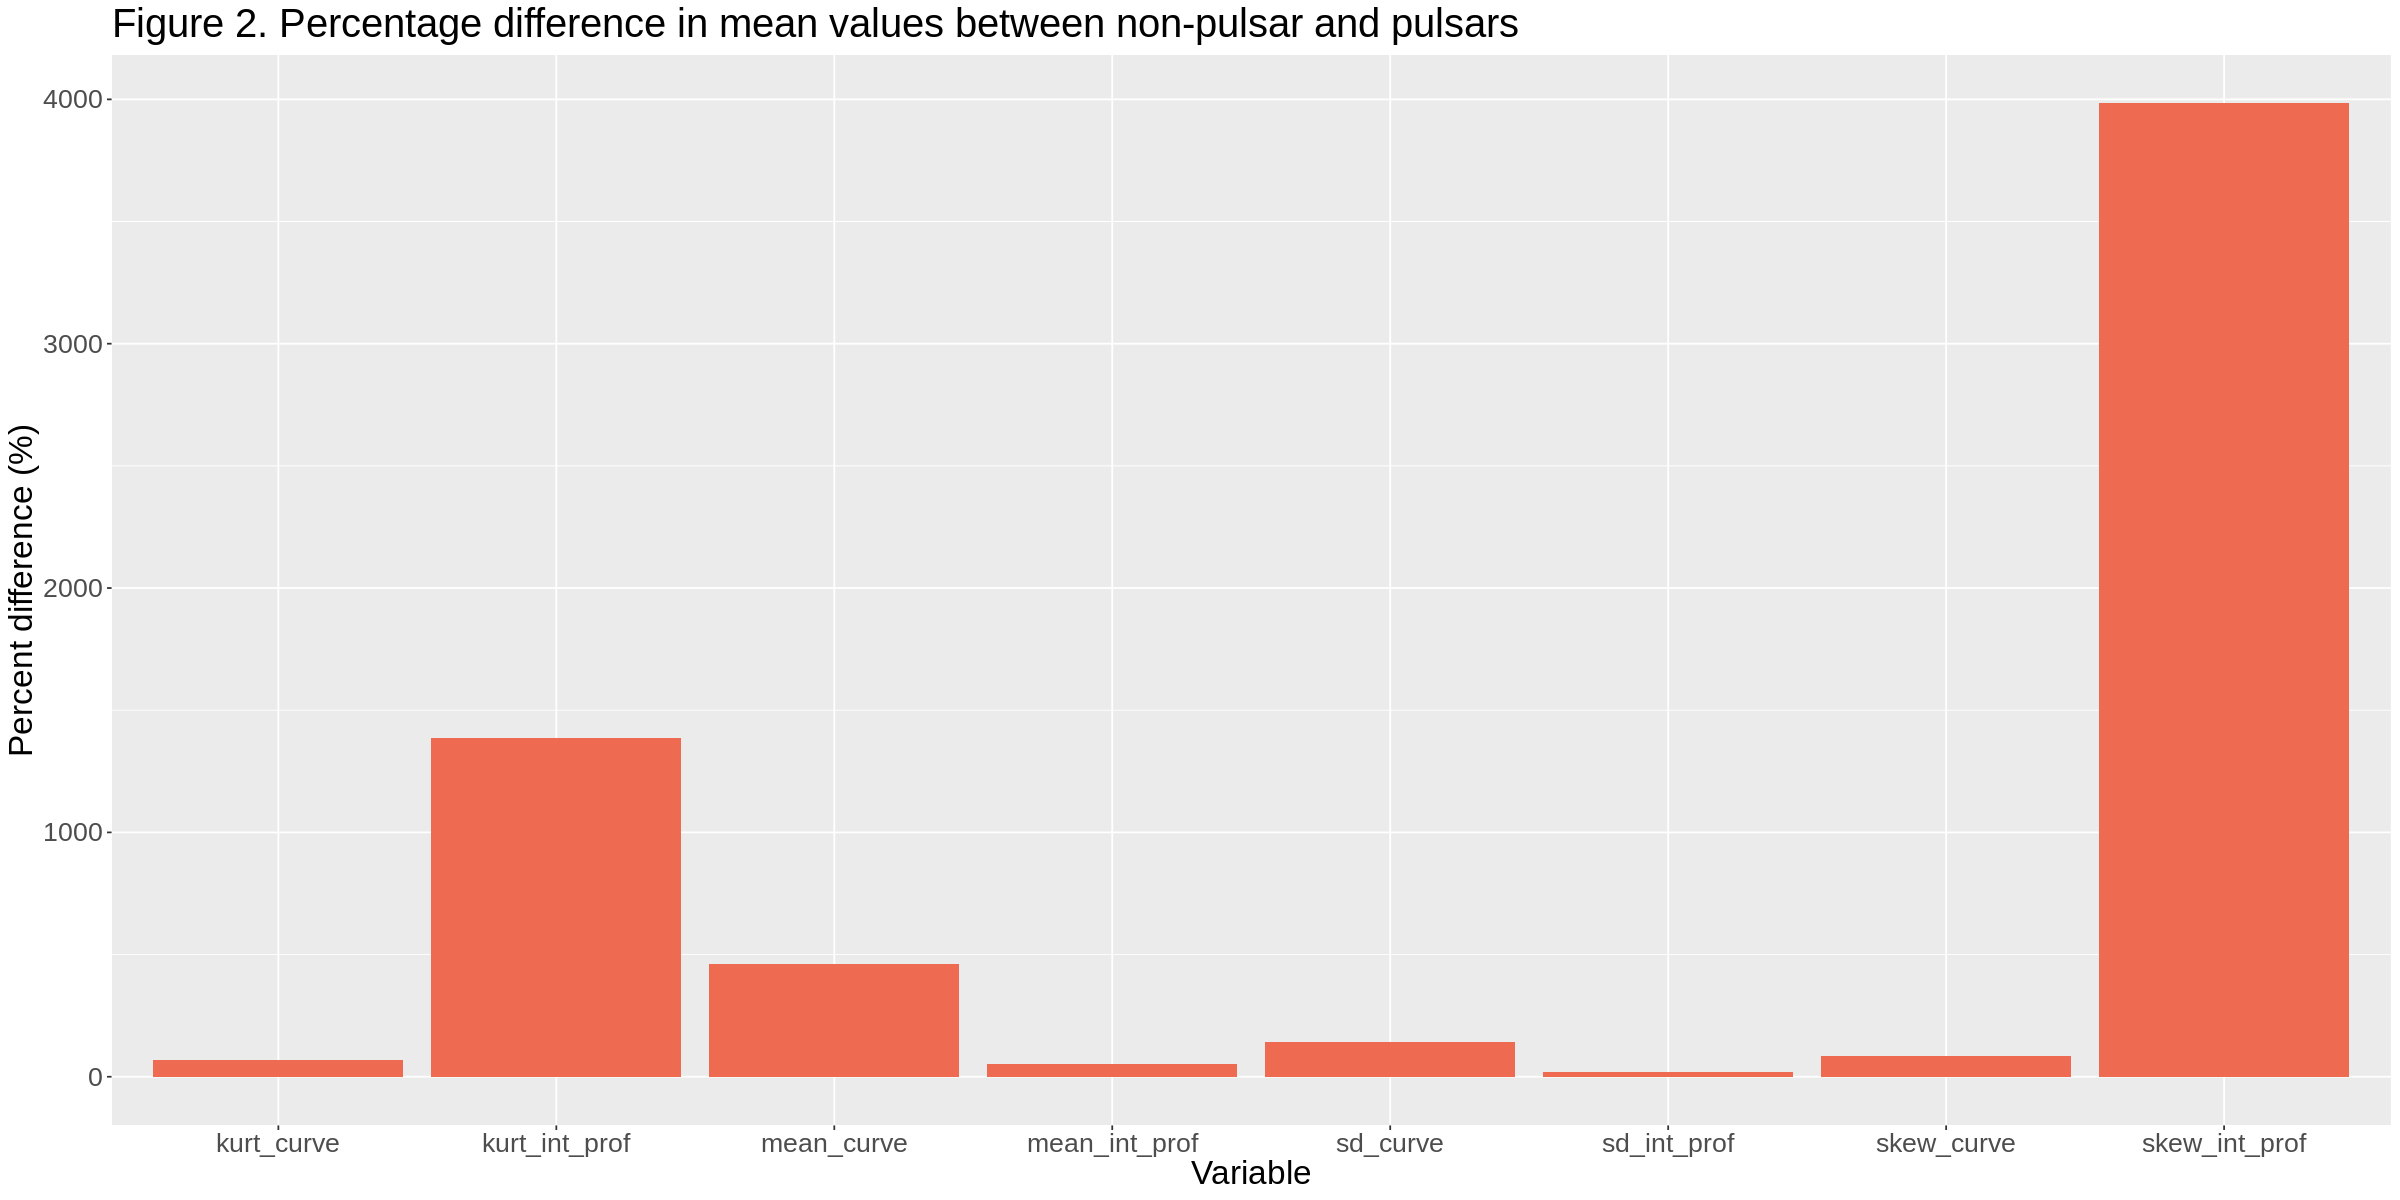

In [10]:
tidy_percentage_diff <- pulsar_percentage_difference %>%
    pivot_longer(cols = mean_int_prof:skew_curve,
                names_to = "variable",
                values_to = "pct_diff")

percentage_diff_viz <- tidy_percentage_diff %>%
    ggplot(aes(x = variable, y = pct_diff)) +
    geom_bar(stat = "Identity", fill = "coral2") +
    labs(x = "Variable", y = "Percent difference (%)") +
    theme(text = element_text(size=20)) +
    ggtitle("Figure 2. Percentage difference in mean values between non-pulsar and pulsars")
    
percentage_diff_viz

The three variables with highest values from Figure 2 (kurt_int_prof, mean_curve and skew_int_prof) will then be used as predictors for our data analysis. kurt_int_prof indicates the excess kurtosis of the integrated profile, skew_int_prof indicates the skewness of the integrated profile, and mean_curve indicates the mean of the DM-SNR curve.

However, before we can start our classifier, we must check how our data is distributed in terms of each class, in order to avoid class imbalance, which will interfere with our classifier's accuracy.

In [20]:
set.seed(2022) 

pulsar <- which(pulsar_data$class=="1") # making a list of all the entries with Class = 1 (a.k.a. true pulsars)
false <- which(pulsar_data$class=="0")# making a list of all the entries with Class = 0 (a.k.a. false pulsar candidates)

# count how many observations of each category we have
length(pulsar)
length(false)

[1] 1639

[1] 16259

As we have 1,639 true pulsars, and 16,259 false candidates, we can see that our two classes are heavily imbalanced. We can solve this by refitting our data, either by 1.) underfitting or downsampling, which is to reduce the majority class to the size of the minority class, or 2.) overfitting or upsampling, which is to increase the minority class to the size of the majority class. Of course, there are drawbacks to both methods: underfitting leads to loss of information from the minority class, and the duplication of the minority class in overfitting can lead to our classifier seeming more accurate than it really is.

For our dataset, since we have a majority class of 16,259 observations, we will choose to downsample since upsampling would result in 32,518 observations. This is a huge value, and would take a lot of time to run code on. An underfitted dataset would only have 3,278 observations, therefore it'll be far more efficient to choose this option. 

In [21]:
# in order to underfit our data, we load a new library with the tools to do so, called caret
library(caret)

In [22]:
set.seed(2022)

# creating an underfitted data set
down <- c(sample(false,length(pulsar)),pulsar)

# here we are making a new vector, combining the true pulsars and a new random sample of false candidates that has the same length as true pulsars
length(down) # the total amount of observations we have in the "down" vector, we can see
pulsar_down <- pulsar_data[down,] # create new pulsar_data dataframe including the indices in "down" (our underfitted data set)
summary(pulsar_down) # we can see a summary of our new underfitted data set
# looking at the class variable, we see we have an even amount of class = 0 and class = 1 (1639 of each!)

[1] 3278

 mean_int_prof      sd_int_prof    kurt_int_prof     skew_int_prof     
 Min.   :  5.812   Min.   :24.77   Min.   :-1.8760   Min.   :-1.59365  
 1st Qu.: 54.268   1st Qu.:36.58   1st Qu.: 0.1814   1st Qu.: 0.06486  
 Median : 95.512   Median :43.69   Median : 0.6357   Median : 1.24321  
 Mean   : 86.459   Mean   :43.12   Mean   : 1.6690   Mean   : 7.95201  
 3rd Qu.:117.441   3rd Qu.:49.21   3rd Qu.: 2.9610   3rd Qu.:11.60289  
 Max.   :192.617   Max.   :83.80   Max.   : 8.0695   Max.   :68.10162  
   mean_curve          sd_curve        kurt_curve       skew_curve      
 Min.   :  0.2132   Min.   :  7.37   Min.   :-2.449   Min.   :  -1.938  
 1st Qu.:  2.4971   1st Qu.: 17.09   1st Qu.: 1.654   1st Qu.:   1.701  
 Median :  6.8428   Median : 32.56   Median : 5.235   Median :  28.206  
 Mean   : 29.3071   Mean   : 39.86   Mean   : 5.864   Mean   :  67.867  
 3rd Qu.: 39.5928   3rd Qu.: 62.06   3rd Qu.: 9.029   3rd Qu.:  97.495  
 Max.   :207.3027   Max.   :109.66   Max.   :34.540   Max.

Now we have successfully created a downsampled dataset, and we can see that it has 1,639 observations of each class. We can proceed to splitting our newly refitted data into training and testing subsets.

In [23]:
set.seed(2022)

# initial split for underfitted data
# question: should we add split for unfitted data for comparison?

pulsar_down_split <- initial_split(pulsar_down, prop = 0.75, strata = class)  
pulsar_down_train <- training(pulsar_down_split)   
pulsar_down_test <- testing(pulsar_down_split)

With our training set, we can make a recipe using the three variables we singled out earlier.

In [24]:
set.seed(2022)

pulsar_down_recipe <- recipe(class ~ kurt_int_prof + mean_curve + skew_int_prof,
                       data = pulsar_down_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
pulsar_down_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

We can't go straight into building our classifier, since we must first find an optimal value of k, or the number of neighbours. In order to obtain the best estimate of accuracy, we will perform a 5-fold cross-validation on our training data to avoid inaccuracies caused by random split of the validation/training sets. 

In [25]:
set.seed(2022)

# split our training data into 5 folds, preparing for cross-validation
pulsar_down_vfold <- vfold_cv(pulsar_down_train, v = 5, strata = class)

# build tuning model
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

# run cross-validation and collect results 
knn_down_results <- workflow() %>%
    add_recipe(pulsar_down_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = pulsar_down_vfold, grid = 10) %>%
    collect_metrics

Now, it's time to plot our results in order to decide on the optimal k-value:

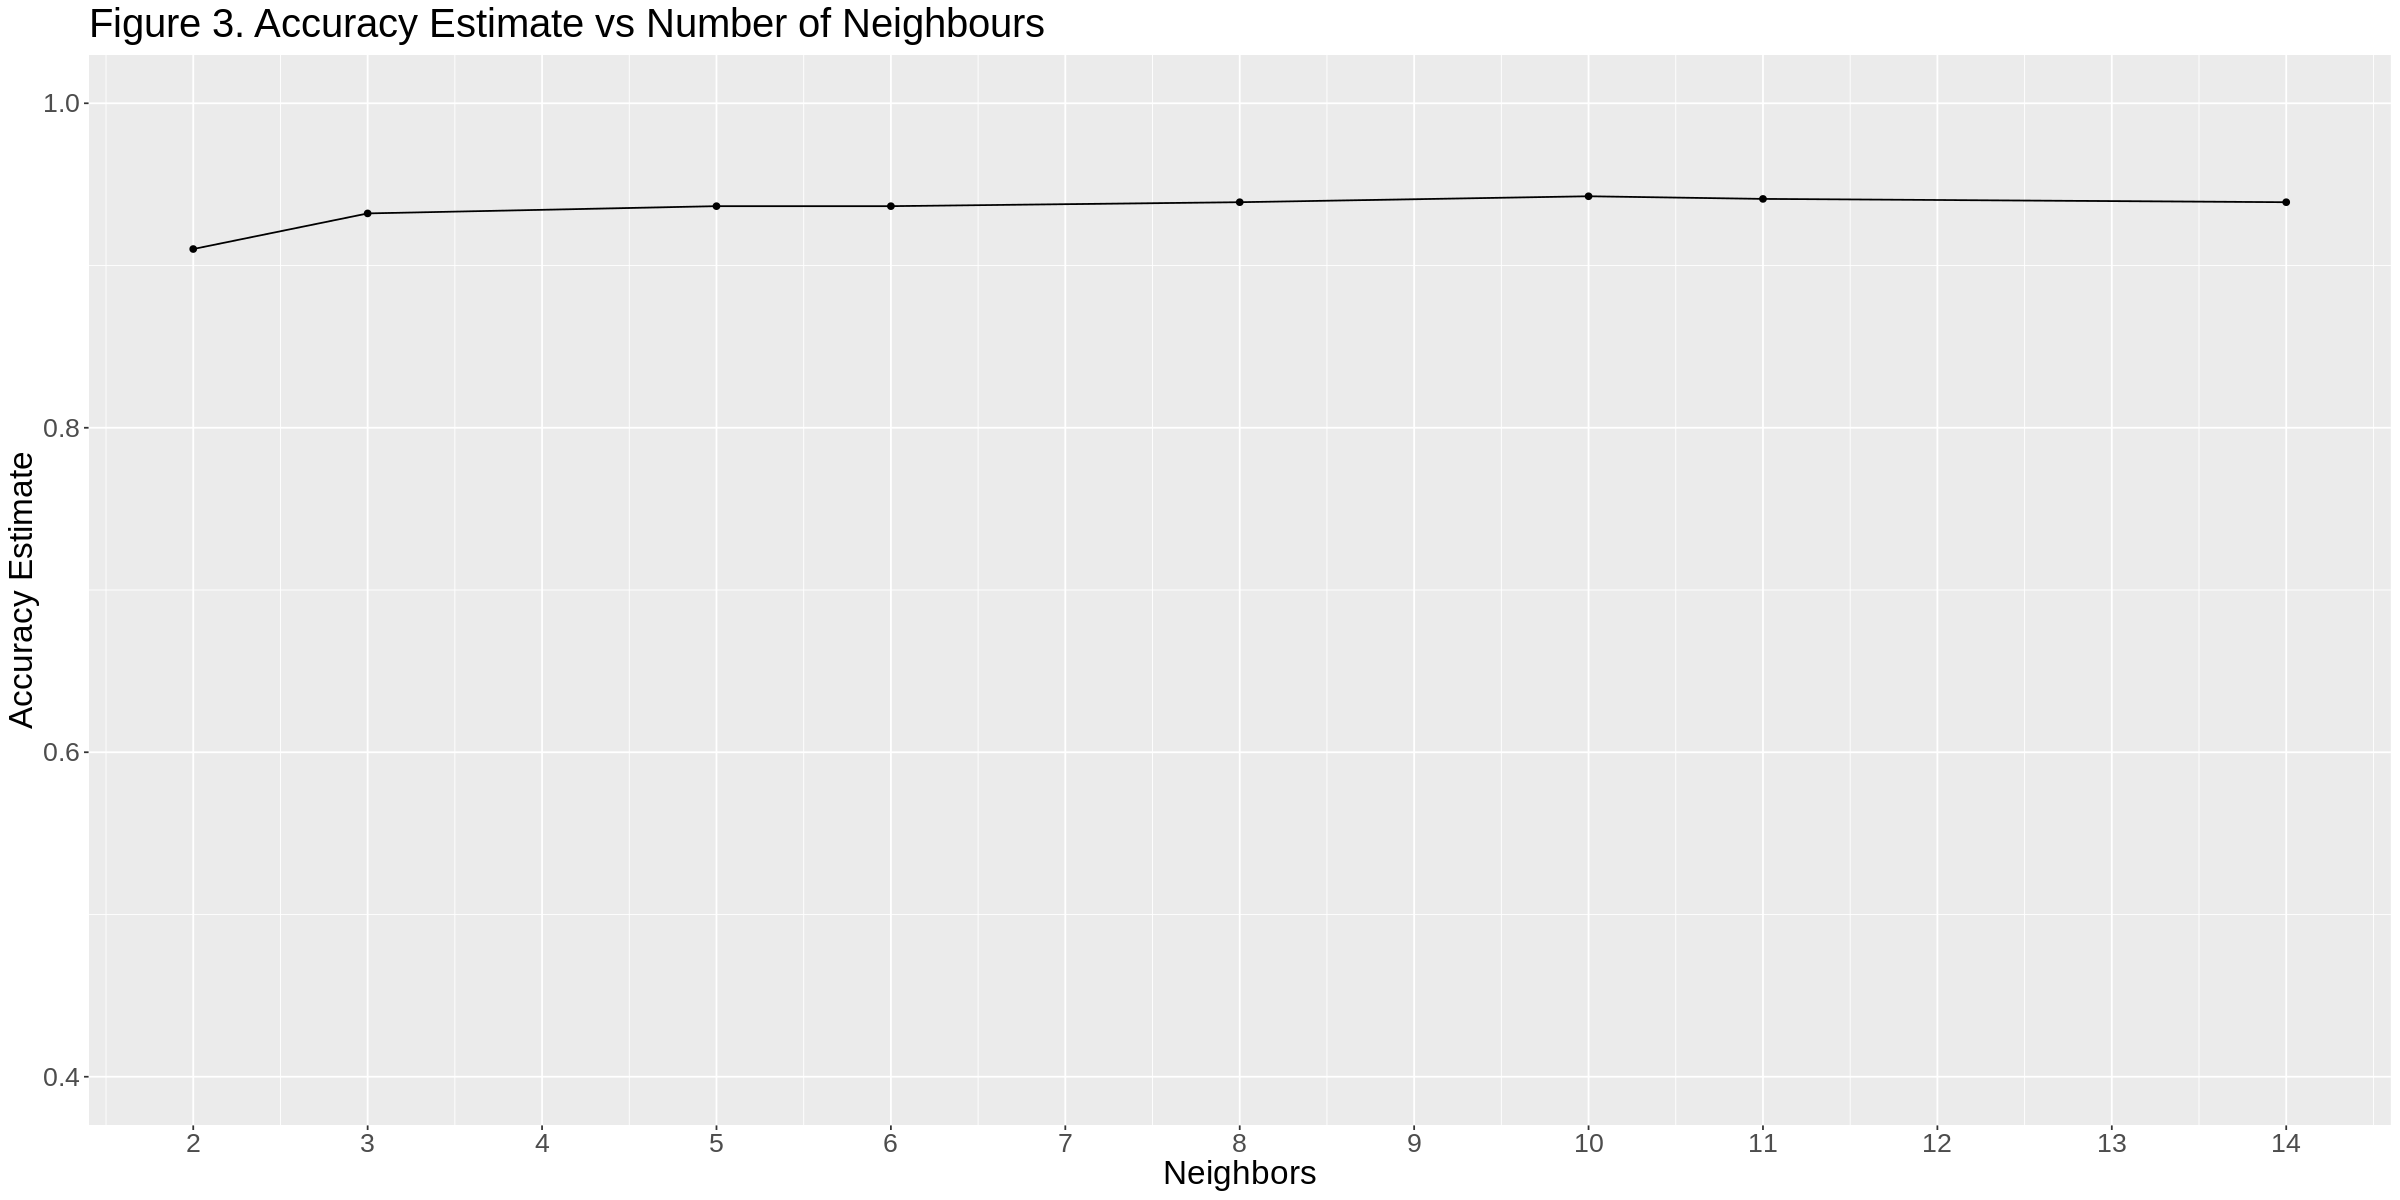

In [26]:
set.seed(2022)

# filter for the accuracy reports only
accuracies_down <- knn_down_results %>%
    filter(.metric == "accuracy")

# create a plot of estimated accuracy vs k-value
cross_val_plot_down <- ggplot(accuracies_down, aes(x= neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size=20)) +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 1.0)) + # adjusting the y-axis
    ggtitle("Figure 3. Accuracy Estimate vs Number of Neighbours")
cross_val_plot_down

For our analysis, we will be using k = 10, since the accuracy estimate seems to be the highest between k-values 9-11 (Figure 3). We choose 10 since it is in the middle of a good range: as the accuracy report is only an estimate, the actual estimate could be different, and so we want to find a range of good values in our estimate and pick one in the middle of that range.

Now that we've chosen our k-value, it's time to build our classifier. We can re-use our recipe here, but we build a new knn-model with our chosen k of 10 since our previous model was meant for tuning.

In [27]:
set.seed(2022)

# knn model using our chosen k-value
knn_spec_down <- nearest_neighbor(weight_func = 'rectangular', neighbors = 10) %>%
    set_engine('kknn') %>%
    set_mode('classification')

# build workflow using the new model
pulsar_down_workflow <- workflow() %>%
    add_recipe(pulsar_down_recipe) %>%
    add_model(knn_spec_down)
pulsar_down_workflow

# run workflow on our training data
pulsar_down_fit <- pulsar_down_workflow %>%
    fit(data = pulsar_down_train)

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 10
  weight_func = rectangular

Computational engine: kknn 


Now that we've built our classifier, it's time to test it using our testing data and see how accurate it is.

In [28]:
set.seed(2022)

# summary of how well our classifier works on the testing data
pulsar_down_summary <- pulsar_down_fit %>%
    predict(pulsar_down_test) %>%
    bind_cols(pulsar_down_test) %>%
    metrics(truth = class, estimate = .pred_class)
pulsar_down_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9364303
kap,binary,0.8728606


A 93.64% accuracy sounds quite good, but what does this value actually mean? How accurate is our classifier really? Let's compare it to the majority classifier:

In [22]:
#check majority class to compare
pulsar_down_proportions <- pulsar_down_train %>%
                      group_by(class) %>%
                      summarize(n = n()) %>%
                      mutate(percent = 100*n/nrow(pulsar_down_train))
pulsar_down_proportions

`summarise()` ungrouping output (override with `.groups` argument)



class,n,percent
<fct>,<int>,<dbl>
0,1230,50
1,1230,50


Since we are testing on underfitted data, our data split is exactly 50/50, meaning that the accuracy of the majority classifier would be 50%. Our classifier is far more accurate than the majority classifier, which is great.

Let's analyze the confusion matrix to see what our data is getting wrong, to see if there is a common mistake that the classifier makes.

In [21]:
set.seed(2022)

# summary of what our data is getting wrong
conf_summary <- pulsar_down_fit %>%
    predict(pulsar_down_test) %>%
    bind_cols(pulsar_down_test) %>%
    conf_mat(truth = class, estimate = .pred_class)
conf_summary

          Truth
Prediction   0   1
         0 402  45
         1   7 364

The confusion matrix shows us that 402 false candidates and 364 true pulsars were correctly classified. 45 true pulsars were incorrectly labelled as false, and 7 false candidates were incorrectly labelled as true. This means that our classifier tends to mistake true pulsars as false candidates.

### Discussion 

Our classifier was able to distinguish pulsar observations from non-pulsars with an accuracy of 93.62%. This is much higher than the majority classifier accuracy of 50% for our data set. The confusion matrix indicated that our classifier tended to mistake true pulsars for false candidates rather than the inverse, which means that there are fewer false positives than false negatives. This means that the observations labelled as true pulsars by our classifier is likely to be accurate, but the observations labelled as false candidates likely contain mislabelled true pulsars. Therefore, our classifier may be helpful for scientific research regarding pulsars. It would be less applicable to scientific research if the classifier tended towards false positives than false negatives, because scientists are not concerned with noise observations and so the accuracy of classifying them matters less. 

We expected to be able to develop an accurate classifier to parse out non-pulsars from pulsar observations based on the mean of the DM-SNR curve, excess kurtosis of the integrated profile, and the skewness of the integrated profile of the observations. We chose those variables as predictors since they were the variables with the highest relative difference out of all of the variables in the HTRU2 data set. We were able to make a classifier that labelled pulsar candidates with higher accuracy than the majority classifier, which matches our expected outcomes. 

An accurate pulsar/non-pulsar classifier may be able to help scientists parse through large data sets to filter out pulsars from noise, since pulsars are of high interest to scientific study. Pulsars, due to their lighthouse-like behaviour, are tools to help with research regarding extreme states of matter and exoplanets. It is complicated to determine whether pulsar candidates are real pulsars or not, so having an accurate classifier may greatly improve efficiency. Since our classifier works accurately, we have evidence that suggests a link between the variables we used as predictors (excess kurtosis and skewness of the mean integrated profile and mean of the DM-SNR curve) and pulsar status. One question that arises is how those variables relate to one another, beyond being individually considered? 



### Works Cited
Agarwal, N., Limam, M., Das, T. (2020, August 26). Predicting pulsar star: Pulsar candidates collected during the high time resolution universe survey. Kaggle. Retrieved April 9, 2022, from https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate

Castro, M. (2020, September 18). How to resolve class imbalance in R. YouTube. Retrieved April 9, 2022, from https://www.youtube.com/watch?v=bWD9Bmrru44&amp;ab_channel=MarioCastro 

Keith, M.J., Jameson, A., van Straten, W., Bailes, M., Johnston, S., Kramer, M., Possenti, A., 
    Bates, S.D., Bhat, N.D.R., Burgay, M. (2010). The High Time Resolution Universe Pulsar Survey — I. System configuration 
    and initial discoveries. Monthly Notices of the Royal Astronomical Society, 409(2), 619—627. Doi: 10.111/j.1365-
    2966.2010.17325.x
    
Lyon, R. J. (2016a). Why are pulsars hard to find?. The University of Manchester (United Kingdom).
    
Lyon, R.J., Stappers, B.W., Cooper, S., Brooke, J.M., Knowles, J.D. (2016b). Fifty years of pulsar 
    candidate selection: From simple filters to a new principled real-time classification approach. Monthly Notices of the 
    Royal Astronomical Society, 459(1), 1104—1123. Doi: 10.1093/mnras/stw656. 

NASA. (2014, February 10). NASA | What is a pulsar? Youtube. Retrieved April 9, 2022, from https://www.youtube.com/watch?v=gjLk_72V9Bw&ab_channel=NASAGoddard

